# Mini AI Pipeline for Damage Recognistion using Roof Detection
##*Reece Jones*
##*2025848556*

###Overview:
This mini pipeline shows a comarison between a naive computer vison pipeline and a transformer based model to recognise damage after a natural disaster. The pipeline uses a dataset made up of 72 satellite images with 36 being taken before a natural disaster, and the other 36 being taken after the event.



# _Installations_

In [1]:
!pip install transformers opencv-python pillow numpy torch matplotlib pandas

In [1]:
import os
from PIL import Image
from itertools import product

# 1. Setup folders
dataset_dir = "roofs_destroyed_dataset"
os.makedirs(dataset_dir, exist_ok=True)

# 2. Settings
target_images = [
    "philippines-before.jpg", "philippines-after.jpg",
    "oklahoma-before.jpg", "oklahoma-after.jpg",
    "japan-before.jpg", "japan-after.jpg",
    "sendai-before.jpg", "sendai-after.jpg",
]
grid_size = 3  # 3x3 grid = 9 images per photo

def slice_image(filename):
    if not os.path.exists(filename):
        print(f"Skipping {filename}: Not found.")
        return

    img = Image.open(filename)
    w, h = img.size

    # Calculate slice size
    d_w = w // grid_size
    d_h = h // grid_size

    grid = product(range(0, h-h%d_h, d_h), range(0, w-w%d_w, d_w))

    count = 0
    base_name = filename.split(".")[0]

    for i, j in grid:
        # Define the box to cut (left, upper, right, lower)
        box = (j, i, j+d_w, i+d_h)

        # Cut and save
        out_img = img.crop(box)
        save_path = f"{dataset_dir}/{base_name}_slice_{count}.jpg"
        out_img.save(save_path)
        count += 1

    print(f"✅ Sliced {filename} into {count} images.")

# 3. Run Slicer
print("Generating Dataset...")
for img_name in target_images:
    slice_image(img_name)

print(f"\n Dataset Generation Complete!")
print(f"Total Examples Created: {len(os.listdir(dataset_dir))}")

Generating Dataset...
✅ Sliced philippines-before.jpg into 9 images.
✅ Sliced philippines-after.jpg into 9 images.
✅ Sliced oklahoma-before.jpg into 9 images.
✅ Sliced oklahoma-after.jpg into 9 images.
✅ Sliced japan-before.jpg into 9 images.
✅ Sliced japan-after.jpg into 9 images.
✅ Sliced sendai-before.jpg into 9 images.
✅ Sliced sendai-after.jpg into 9 images.

 Dataset Generation Complete!
Total Examples Created: 72


# _Import List_

In [2]:
#import list

import cv2
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from PIL import Image
from transformers import AutoImageProcessor, AutoModelForObjectDetection

# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# _Import Transformer_

In [3]:
#Import base model from huggingface
model = AutoModelForObjectDetection.from_pretrained("Yifeng-Liu/rt-detr-finetuned-for-satellite-image-roofs-detection")
image_processor = AutoImageProcessor.from_pretrained("Yifeng-Liu/rt-detr-finetuned-for-satellite-image-roofs-detection")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/307M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


# _Define AI Pipeline_

In [12]:
# Define AI model
def count_roof_ai(filename):

  try:
    image=Image.open(filename).convert("RGB")

  except Exception:
    print("Error: Unable to load image, (AI)")
    return 0

  CONFIDENCE_TRESHOLD = 0.3

  with torch.no_grad():
     model.to(device)

    # load image and predict
     inputs = image_processor(images=image, return_tensors='pt').to(device)
     outputs = model(**inputs)

    # post-process
     target_sizes = torch.tensor([image.size[::-1]]).to(device)
     results = image_processor.post_process_object_detection(
        outputs=outputs,
        threshold=CONFIDENCE_TRESHOLD,
        target_sizes=target_sizes
     )[0]
     return len(results['boxes'])

# _Define Naive Model_

In [19]:
# Define Naive model
def count_roof_naive(filename):

    # load image
    img = cv2.imread(filename)

    if img is None:
       print("Error: Unable to load image, (naive)")
       return 0

    # covert image to hsv (hue, saturation, value)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # set upper and lower bounds of detection
    lower_grey = np.array([0, 0, 100])
    upper_grey = np.array([100, 50, 250])

    # create a mask for the image: detected pixels turn white, others turn black
    mask = cv2.inRange(hsv, lower_grey, upper_grey)

    # count the number of white pixels in the mask, which represent potential roofs
    white_pixle = cv2.countNonZero(mask)

    # estimate the number of roofs by dividing the total white pixels by an average roof size
    estimate_count = int(white_pixle / 500)

    return estimate_count


# _Compute Comparison on the Dataset_

In [20]:
#evaluate both models on a random image pair

#set dataset
dataset_folder = "roofs_destroyed_dataset" # MAKE SURE TO CHECK DATASET FOLDER NAME IF THE DATASET IS CHANGED

if not os.path.exists(dataset_folder):
  print("Error: folder not found")

else:

  # sort files in the dataset
  all_files = sorted(os.listdir(dataset_folder))

  # filter for images taken before the disaster
  before_images = [f for f in all_files if "-before_" in f] # MAKE SURE TO CHECK DATASET FILENAMES IF THE DATASET IS CHANGED

  # create an empty list for the results
  results = []

  print(f"processing {len(before_images)} pairs ...")

  # go through the before images and get the corresponding after image
  for filename_before in before_images:

      # construct the filename for the after image
      filename_after = filename_before.replace("-before_", "-after_") # MAKE SURE TO CHECK DATASET FILENAMES IF THE DATASET IS CHANGED

      # create paths for both the before image and after image
      before_path = os.path.join(dataset_folder, filename_before)
      after_path = os.path.join(dataset_folder, filename_after)

      # check if the after image exists
      if os.path.exists(after_path):
          try:
              # run the naive pipeline for the pair of images
              n_pre = count_roof_naive(before_path)
              n_post = count_roof_naive(after_path)

              # run the AI pipeline for the pair of images
              a_pre = count_roof_ai(before_path)
              a_post = count_roof_ai(after_path)

              # append the results (location, naive difference, AI difference) to the results list
              results.append({
                  "location": filename_before.replace("-before_", "").replace(".jpg", ""), # MAKE SURE TO CHECK DATASET FILENAMES IF THE DATASET IS CHANGED
                  "naive_diff": n_pre - n_post,
                  "ai_diff": a_pre - a_post
              })

          except Exception as e:

              # print an error message if processing fails for a pair of images
              print(f"skipped {filename_before} and {filename_after}: {e}")

  print(f"{len(results)} paires processed")

processing 36 pairs ...
36 paires processed


# _Visualise Results_


Results =
Naive Logic Failures (Negative Damage): 15
AI Logic Failures (Negative Damage):    4
Graph saved as 'final_result_graph.png'


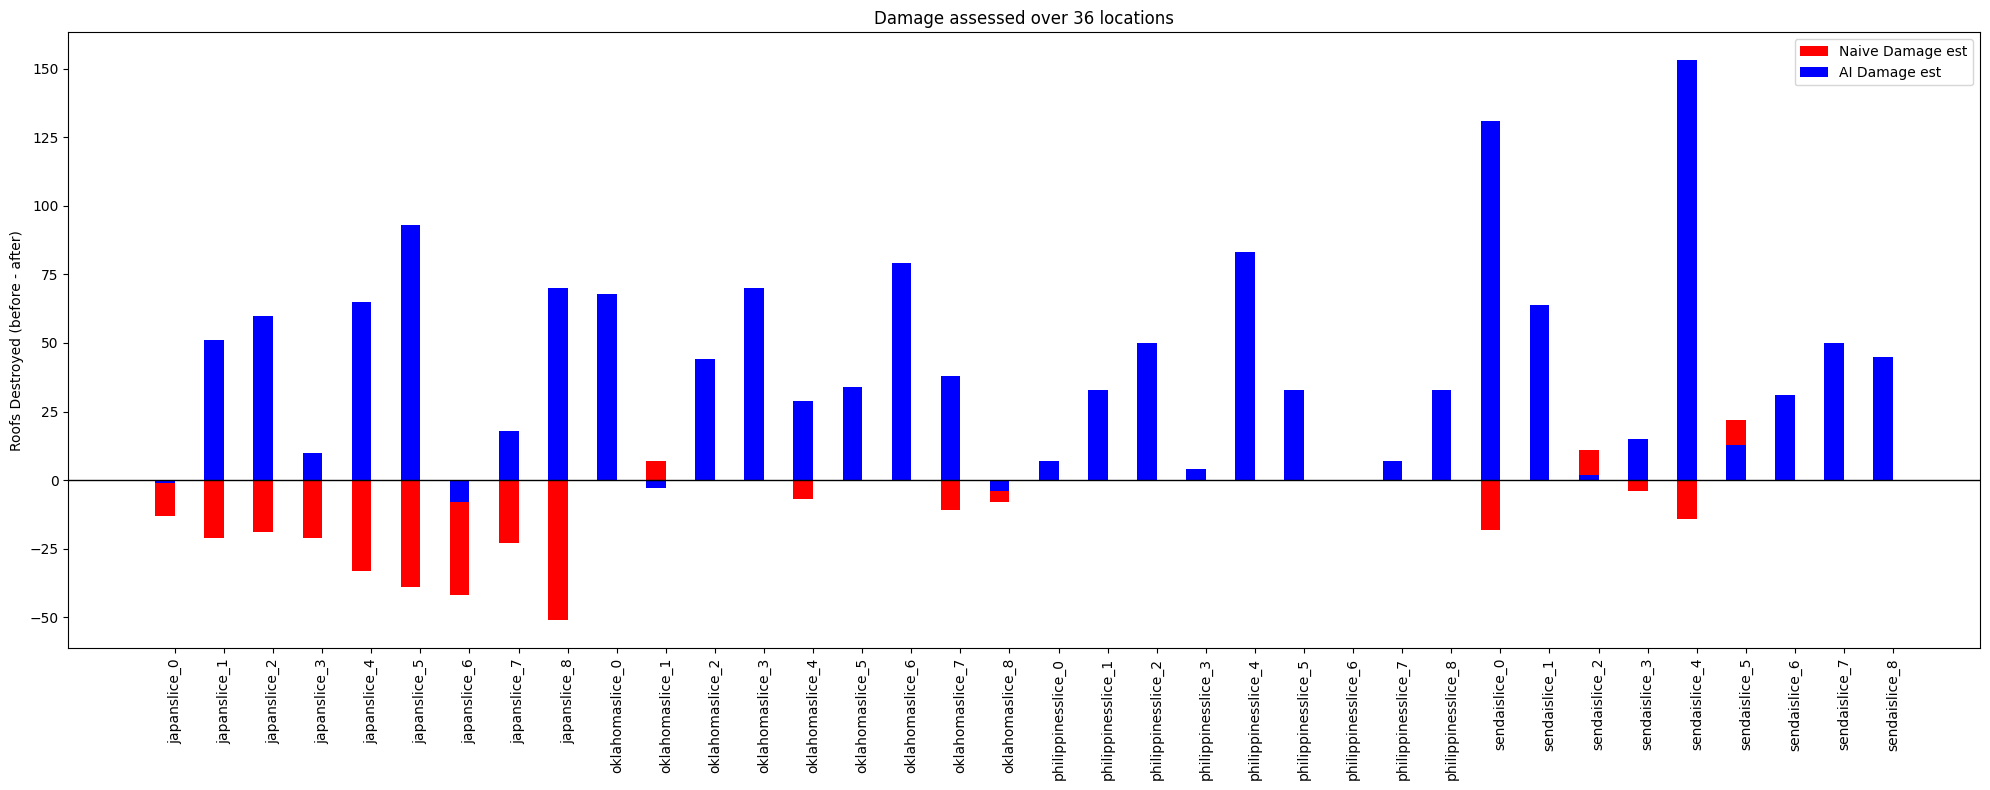

In [21]:
#visualisation of comparison


# check if there are enough successful results
if len(results)> 1:

    # conver the results into a dataframe using pandas
    df =pd.DataFrame(results)

    # count how many times the naive model gave a negitive difference (meaning more roofs after than before)
    naive_fail=len(df[df["naive_diff"]<0])
    # count how many times the AI model gave a negitive difference (meaning more roofs after than before)
    ai_fail=len(df[df["ai_diff"]<0])

    print ("\nResults =")
    print(f"Naive Logic Failures (Negative Damage): {naive_fail}")
    print(f"AI Logic Failures (Negative Damage):    {ai_fail}")


#plot results

    # Create a figure for the plot with a specified size
    plt.figure(figsize=(20,8))
    x = range(len(df))
    width= 0.4

    # plot the bars, lable the axis and legend and format the plot correctly
    plt.bar([i - width/2 for i in x], df["naive_diff"], width, label="Naive Damage est", color= "red")
    plt.bar([i - width/2 for i in x], df["ai_diff"], width, label="AI Damage est", color= "blue")
    plt.axhline(0, color="black", linewidth=1)
    plt.xticks(x, df["location"], rotation=90)
    plt.title(f"Damage assessed over {len(df)} locations")
    plt.ylabel("Roofs Destroyed (before - after)")
    plt.legend()
    plt.tight_layout()

    # save the plot as a file
    plt.savefig("final_result_graph.png")
    print("Graph saved as 'final_result_graph.png'")

# If no matching pairs were evaluated, print a message
else:
    print("no matching pairs evaluated")